In [188]:
import numpy as np
import sacc
import matplotlib.pyplot as plt
import pyccl as ccl
import scipy
import importlib as imp

import CM_code.spurious_george as sp
imp.reload(sp)
import CM_code.halo_model as halo
imp.reload(halo)
import CM_code.lsst_coZmology as zed
imp.reload(zed)

# import main.py from TJPCov folder
import tjpcov as tjp

In [189]:
# import LSST SRD cosmology from CM modules
cosmo = zed.cosmo_SRD

# import frequently used values from spurious george
th_min = sp.theta_min
th_max = sp.theta_max
th_bins = sp.theta_cents
N_bins = sp.N_bins

d2r = np.pi / 180.

In [190]:
# Start by constructing the tracers
z_l, dndz_l, zleff = zed.get_dndz_spec('source')
z_s, dndz_s, zseff = zed.get_dndz_spec('lens')

A_IA = 5. * np.ones(len(z_l))

lensTracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_l, dndz_l), 
                                    bias=(z_l, sp.lens_bias(z_l)))
shearTracer = ccl.WeakLensingTracer(cosmo, (z_s, dndz_s), has_shear=True, 
                                     ia_bias=(z_s, A_IA))

### Next we set all the parameter data that TJP will need

In [191]:
ell = np.unique(np.geomspace(180/(sp.theta_max/60.) - 10, 
                             180/(sp.theta_min/60.) + 10, 
                             1024).astype(int))

Cgg_data.metadata['info'] = 'Cl_gg for LSST-like lenses and sources'

Cgg_data.metadata['fsky'] = sp.pa.fsky # fsky from Danielle's LSST params

# TJP wants theta in DEGREES
Cgg_data.metadata['th_bins'] = th_bins/60.

# WHAT IS GOING ON HERE??? - Q. still stands, didn't have time to talk about it
th=np.logspace(np.log10(th_min*0.98),np.log10(1.),N_bins*30)
th2=np.linspace(1.,th_max*1.02,N_bins*30) 
Cgg_data.metadata['th'] = np.unique(np.sort(np.append(th,th2)))

# Add ell values to meta data
Cgg_data.metadata['ell'] = ell
Cgg_data.metadata['ell_bins'] = np.linspace(ell[0],ell[-1],60)

thb=0.5*(Cgg_data.metadata['th_bins'][1:]+Cgg_data.metadata['th_bins'][:-1])

In [192]:
#compute a single covariance matrix for a given pair of C_ell or xi.  
def cl_gaussian_cov(tracer_comb1=None,tracer_comb2=None,ccl_tracers=None,tracer_Noise=None,Cgg_data=None,do_xi=False,
                    xi_plus_minus1='plus',xi_plus_minus2='plus'):  
    #fsky should be read from the sacc
    #tracers 1,2,3,4=tracer_comb1[0],tracer_comb1[1],tracer_comb2[0],tracer_comb2[1]
    ell=Cgg_data.metadata['ell']
    cl={}
    cl[13] = ccl.angular_cl(cosmo, tracer_comb1[0], tracer_comb2[0], ell)
    cl[24] = ccl.angular_cl(cosmo, tracer_comb1[1], tracer_comb2[1], ell)
    cl[14] = ccl.angular_cl(cosmo, tracer_comb1[0], tracer_comb2[1], ell)
    cl[23] = ccl.angular_cl(cosmo, tracer_comb1[1], tracer_comb2[0], ell)
    
    SN={}
    SN[13]=tracer_Noise[tracer_comb1[0]] if tracer_comb1[0]==tracer_comb2[0]  else 0
    SN[24]=tracer_Noise[tracer_comb1[1]] if tracer_comb1[1]==tracer_comb2[1]  else 0
    SN[14]=tracer_Noise[tracer_comb1[0]] if tracer_comb1[0]==tracer_comb2[1]  else 0
    SN[23]=tracer_Noise[tracer_comb1[1]] if tracer_comb1[1]==tracer_comb2[0]  else 0
    
    if do_xi:
        norm=np.pi*4*Cgg_data.metadata['fsky']
    else: #do c_ell
        norm=(2*ell+1)*np.gradient(ell)*Cgg_data.metadata['fsky']

    coupling_mat={}
    coupling_mat[1324]=np.eye(len(ell)) #placeholder
    coupling_mat[1423]=np.eye(len(ell)) #placeholder
    
    cov={}
    cov[1324]=np.outer(cl[13]+SN[13],cl[24]+SN[24])*coupling_mat[1324]
    cov[1423]=np.outer(cl[14]+SN[14],cl[23]+SN[23])*coupling_mat[1423]

        
    cov['final']=cov[1423]+cov[1324]
    
    if do_xi:
        s1_s2_1=get_cov_WT_spin(tracer_comb=tracer_comb1)
        s1_s2_2=get_cov_WT_spin(tracer_comb=tracer_comb2)
        
        if isinstance(s1_s2_1,dict):
            s1_s2_1=s1_s2_1[xi_plus_minus1] 
        if isinstance(s1_s2_2,dict):
            s1_s2_2=s1_s2_2[xi_plus_minus2]
            
        th,cov['final']=WT.projected_covariance(ell_cl=ell,s1_s2=s1_s2_1, s1_s2_cross=s1_s2_2,
                                                      cl_cov=cov['final'])

    cov['final']/=norm
    
    if do_xi:
        thb,cov['final_b']=tjp.wigner_transform.bin_cov(r=th/d2r,r_bins=Cgg_data.metadata['th_bins'],cov=cov['final']) 
    else:
        if Cgg_data.metadata['ell_bins'] is not None:
            lb,cov['final_b']=tjp.wigner_transform.bin_cov(r=ell,r_bins=Cgg_data.metadata['ell_bins'],cov=cov['final']) 
            
#     cov[1324]=None #if want to save memory
#     cov[1423]=None #if want to save memory
    return cov

In [193]:
#compute all the covariances and then combine them into one single giant matrix
def get_all_cov(Cgg_data,tracer_Noise,do_xi=False):
    #FIXME: Only input needed should be Cgg_data, which is the sacc data file. Other parameters should be included within sacc and read from there.

    # we will loop over all these
    N2pt=len(tracer_combs)
    if Cgg_data.metadata['ell_bins'] is not None:
        Nell_bins=len(Cgg_data.metadata['ell_bins'])-1
    else:
        Nell_bins=len(Cgg_data.metadata['ell'])
    if do_xi:
        Nell_bins=len(Cgg_data.metadata['th_bins'])-1
    cov_full=np.zeros((Nell_bins*N2pt,Nell_bins*N2pt))
    for i in np.arange(N2pt):
        print("{}/{}".format(i+1, N2pt))
        tracer_comb1=tracer_combs[i]
        indx_i=i*Nell_bins
        for j in np.arange(i,N2pt):
            tracer_comb2=tracer_combs[j]
            indx_j=j*Nell_bins
            cov_ij=cl_gaussian_cov(tracer_comb1=tracer_comb1,tracer_comb2=tracer_comb2,
                                        tracer_Noise=tracer_Noise,do_xi=do_xi,Cgg_data=Cgg_data)
            if do_xi or Cgg_data.metadata['ell_bins'] is not None:
                cov_ij=cov_ij['final_b']
            else:
                cov_ij=cov_ij['final']
            cov_full[indx_i:indx_i+Nell_bins,indx_j:indx_j+Nell_bins]=cov_ij
            cov_full[indx_j:indx_j+Nell_bins,indx_i:indx_i+Nell_bins]=cov_ij.T
    return cov_full

In [194]:
sigma_mu = sp.pa.sig_e
sigma_nu = sp.pa.sig_e

neff = sp.pa.n_s * 3600. #conver to per sq. degree
nL = sp.pa.n_l

rho = 0.5

In [195]:
tracer_combs = [[lensTracer, lensTracer, 'll'], 
                [shearTracer, shearTracer, 'ss'], 
                [lensTracer, shearTracer, 'ls'], 
               [shearTracer, lensTracer, 'sl']]

mu_Noise = {}
mu_Noise[lensTracer] = 1. / nL
mu_Noise[shearTracer] = sig_mu**2 / neff

nu_Noise = {}
nu_Noise[lensTracer] = 1. / nL
nu_Noise[shearTracer] = sig_nu**2 / neff

rho = 0.5
MuNu_Noise = {}
MuNu_Noise[lensTracer] = 1. / nL
MuNu_Noise[shearTracer] = (rho*sig_mu*sig_nu)/ neff

In [196]:
# Need to define spin of tracers for Wigner Transform
WT_factors={}
WT_factors['ls']=(0,2)
WT_factors['sl']=(2,0)
WT_factors['ll']=(0,0)
WT_factors['ss']={'plus':(2,2),'minus':(2,-2)}

# Set kwargs for Wigner Transform (fourier space transform so need theta and ell)
WT_kwargs={'ell': Cgg_data.metadata['ell'],
           'theta': Cgg_data.metadata['th']*d2r, 's1_s2':[(2,2),(2,-2),(0,2),(2,0),(0,0)]}
%time WT = tjp.wigner_transform.WignerTransform(**WT_kwargs)

def get_cov_WT_spin(tracer_comb=None):
    return WT_factors[tracer_comb[2]]

CPU times: user 1.27 s, sys: 8.98 s, total: 10.3 s
Wall time: 11.4 s


In [210]:
cov_mu = cl_gaussian_cov(tracer_comb1=[lensTracer, shearTracer, 'ls'],
                         tracer_comb2=[lensTracer, shearTracer, 'ls'],
                         ccl_tracers=None,
                         tracer_Noise=mu_Noise,
                         Cgg_data=Cgg_data,
                         do_xi=True)
cov_MuNu = cl_gaussian_cov(tracer_comb1=[lensTracer, shearTracer, 'ls'],
                         tracer_comb2=[lensTracer, shearTracer, 'ls'],
                         ccl_tracers=None,
                         tracer_Noise=MuNu_Noise,
                         Cgg_data=Cgg_data,
                         do_xi=True)

In [220]:
cov_IA = 2.*cov_mu['final_b'] + 2.*cov_MuNu['final_b']
print(np.diag(cov_IA))

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.25437952e-03
 2.87441328e-05]


### Modifying Tracer Noise
- Can we pass an IA only tracer that captures noise correlations and encodes the cancellation of shear-dependent APS?

In [62]:
#Now lets investigate the power spectra

Cl_gg = ccl.angular_cl(cosmo, lensTracer, lensTracer, ell)
Cl_gk = ccl.angular_cl(cosmo, lensTracer, shearTracer, ell)
Cl_kk = ccl.angular_cl(cosmo, shearTracer, shearTracer, ell)

Cl_gIA = ccl.angular_cl(cosmo, lensTracer, intrinsicTracer, ell)
Cl_IAIA = ccl.angular_cl(cosmo, intrinsicTracer, intrinsicTracer, ell)

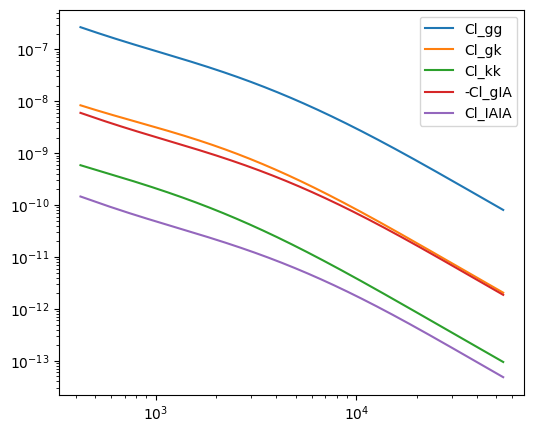

In [63]:
# plot the power spectra

plt.figure(figsize=[6,5])
plt.plot(ell, Cl_gg)
plt.plot(ell, Cl_gk)
plt.plot(ell, Cl_kk)
plt.plot(ell, -Cl_gIA)
plt.plot(ell, Cl_IAIA)
plt.legend(['Cl_gg','Cl_gk','Cl_kk','-Cl_gIA','Cl_IAIA'])
plt.xscale('log')
plt.yscale('log')

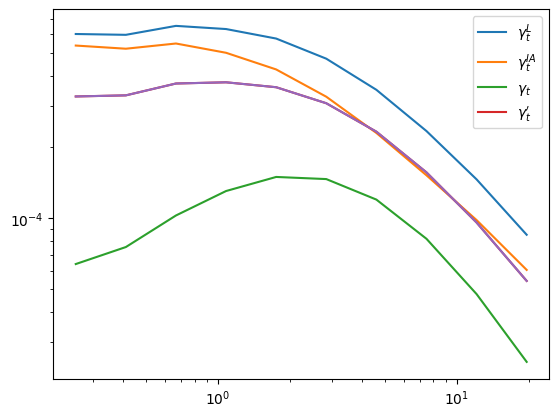

In [85]:
#What about compating gammaT_L and gammaT_IA
# and linearly combining shear + intrinsic tracer
totShear = ccl.WeakLensingTracer(cosmo, (z_s, dndz_s), has_shear=True,
                                   ia_bias=(z_s, a*A_IA))
Cl_gkIA = ccl.angular_cl(cosmo, lensTracer, totShear, ell)

gammaL = ccl.correlation(zed.cosmo_SRD, ell, Cl_gk, th_bins / 60., type='NG')
gammaIA = ccl.correlation(zed.cosmo_SRD, ell, Cl_gIA, th_bins / 60., type='NG')
gammaTest = ccl.correlation(zed.cosmo_SRD, ell, Cl_gkIA, th_bins / 60., type='NG')

a = 0.51

plt.loglog(th_bins, gammaL)
plt.loglog(th_bins, -gammaIA)
plt.loglog(th_bins, gammaL + gammaIA)
plt.loglog(th_bins, gammaL + a*gammaIA)
plt.loglog(th_bins, gammaTest)
plt.legend([r'$\gamma_t^L$',r'$\gamma_t^{IA}$', r'$\gamma_t$', r'$\gamma_t^\prime$'])

[5.85394342e-10 5.85394048e-10 5.85393758e-10 ... 5.85347411e-10
 5.85347411e-10 5.85347411e-10]
[5.85394342e-10 5.85394048e-10 5.85393758e-10 ... 5.85347411e-10
 5.85347411e-10 5.85347411e-10]


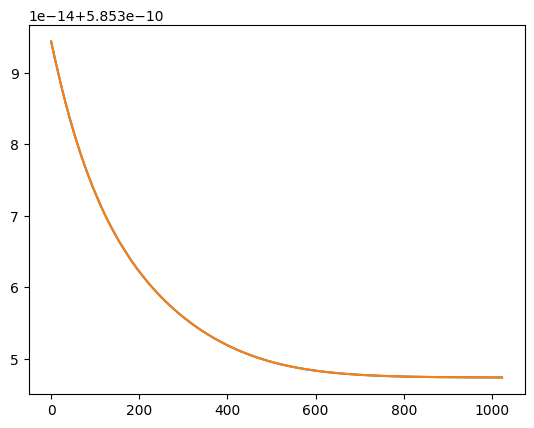

In [43]:
# Ok, so say in theory I calculate the integrand for the final matrix
sigma_mu = sp.pa.sig_e
sigma_nu = sp.pa.sig_e

neff = sp.pa.n_s * 3600. #conver to per sq. degree
nL = sp.pa.n_l

rho = 0.5

# force these to be zero
Cl_gIA = 0.
Cl_IAIA = 0.

All_cl = Cl_gIA**2 + (Cl_gg + 1./nL)*(Cl_IAIA + 
                                      (sigma_mu**2 + sigma_nu**2 - 2.*rho*sigma_mu*sigma_nu)
                                      /neff)

Only_gg = (Cl_gg/neff + 1./(neff*nL)) * (sigma_mu**2 + sigma_nu**2 - 2.*rho*sigma_mu*sigma_nu)

print(All_cl)
print(Only_gg)

plt.plot(All_cl)
plt.plot(Only_gg)